In [2]:
# moduel
from my_package.select_dataset_all import get_all_dataframe_from_database
import my_package.time_series as time

# basic
import pandas as pd
import numpy as np
import pickle

# visualize
import matplotlib.pyplot as plt  

# learning
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

# static
from statsmodels.nonparametric.smoothers_lowess import lowess

C:\Users\pc021\Desktop\프로젝트\테크로스\모델 고도화\시계열 모델\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


<span style="color: blue; font-size: 14px; font-weight: bold; background-color: #f0f0f0; padding: 5px; border-radius: 5px;">
    function
</span>

In [3]:
def loess_smoothing(data, frac=0.1):
    """
    Loess 평활화(Loess Smoothing)를 적용하는 함수
    :param data: 시계열 데이터 (pandas Series)
    :param frac: 데이터에서 학습할 비율 (0에서 1 사이, 클수록 더 부드러운 곡선)
    :return: 평활화된 데이터 (pandas Series)
    """
    smoothed = lowess(data, np.arange(len(data)), frac=frac)[:, 1]
    return pd.Series(smoothed, index=data.index)

# 사용 예시
#df_moving['smoothed'] = loess_smoothing(df_moving['y'], frac=0.05)  # frac값은 0.1로 설정

In [4]:
def exponential_smoothing(data, alpha):
    """
    지수 평활법(Exponential Smoothing)을 적용하는 함수
    :param data: 시계열 데이터 (pandas Series)
    :param alpha: 평활 상수 (0에서 1 사이)
    :return: 평활화된 데이터 (pandas Series)
    """
    return data.ewm(alpha=alpha, adjust=False).mean()

In [5]:
def preprocessing_prophet(df):
    # 분 단위 수정
    #df['DATA_TIME'] = df['DATA_TIME'].dt.strftime('%Y-%m-%d %H:%M')
    
    # 모델 학습을 위한 변수 선택
    df = df[['DATA_TIME','Moving_Average']]
    
    # 분 단위 데이터 그룹화
    group = df.groupby('DATA_TIME').mean()['Moving_Average'].to_frame().reset_index()
    
    # prophet 규칙 
    group.columns =['ds','y']
    
    return group

<span style="color: blue; font-size: 14px; font-weight: bold; background-color: #f0f0f0; padding: 5px; border-radius: 5px;">
    set
</span>

In [6]:
# goals: 데이터 생성 

data = time.create_electrode_data()

In [7]:
# goals: 데이터 처리

ship_name = 'MASAN TEST150'

ship_id = ship_id = time.find_ship(ship_name)[0]

df = time.preprocess_data(data,ship_id)

df= time.generate_moving_average(df,1000)

In [8]:
### goals: 시각화를 이용한 탐색적 데이터 분석

df_moving = df[['Moving_Average']].reset_index(drop=True)

In [9]:
# goals: 1분 단위로 '2023-01-01'부터 datetime 생성

time_series = pd.date_range(start='2023-01-01 00:00', periods=len(df_moving), freq='T')

<span style="color: blue; font-size: 14px; font-weight: bold; background-color: #f0f0f0; padding: 5px; border-radius: 5px;">
    Prophet Model
</span>

#### 데이터 평활

In [10]:
# golas: prophet 맞춘 데이터 프레임 생성

df_moving['time_series'] = time_series
df_moving = df_moving[['time_series','Moving_Average']]
df_moving.columns=['ds','y']

In [11]:
# goals: prophet 처리를 위한 평활화

df_moving['smoothed'] = exponential_smoothing(df_moving['y'], alpha=0.3)  # 알파 값은 0.3으로 설정

In [12]:
# goals: 변수 선택 

df_moving = df_moving[['ds','smoothed']]
df_moving.columns = ['ds','y']

<Axes: >

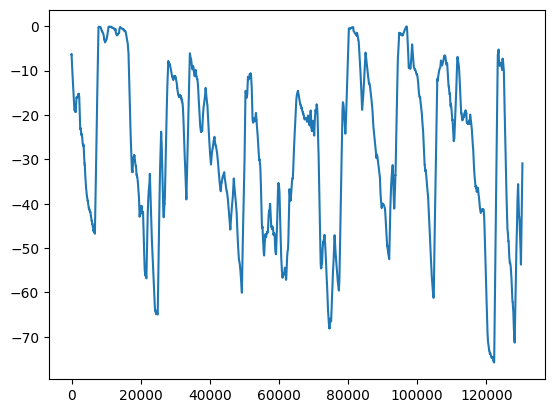

In [13]:
df_moving['y'].plot()

In [16]:
df_moving[:100000]

,ds,y
0,2023-01-01 00:00:00,-6.288000
1,2023-01-01 00:01:00,-6.279000
2,2023-01-01 00:02:00,-6.251400
3,2023-01-01 00:03:00,-6.241380
4,2023-01-01 00:04:00,-6.234366
...,...,...
99995,2023-03-11 10:35:00,-10.927081
99996,2023-03-11 10:36:00,-10.930057
99997,2023-03-11 10:37:00,-10.934540
99998,2023-03-11 10:38:00,-10.938578


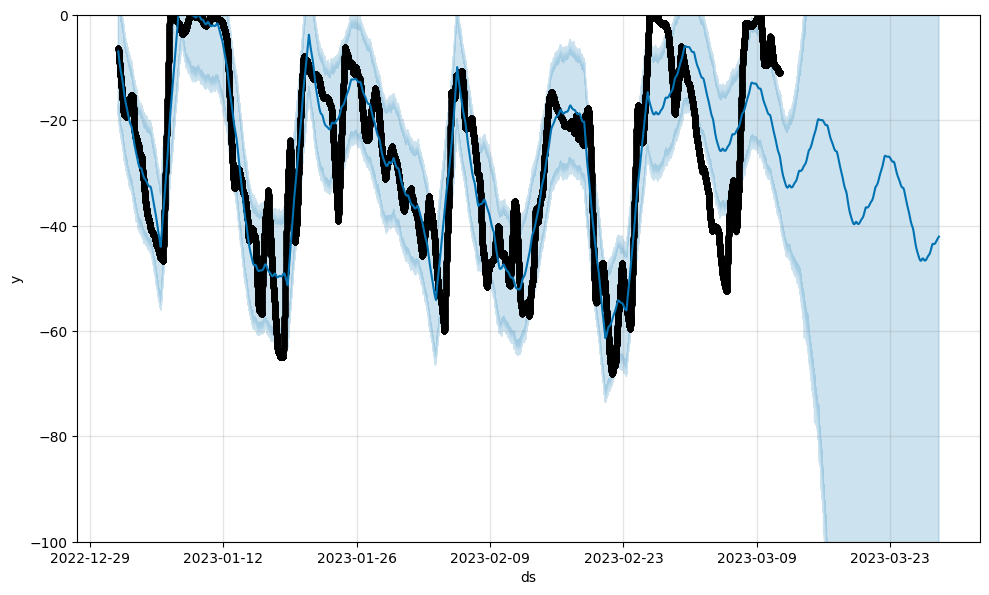

In [20]:
# golas: prophet 사용

# Prophet 모델 생성 및 학습
#model = Prophet(changepoint_prior_scale=0.2)
#model.fit(df_moving[:100000])

# 향후 30일 예측 (필요에 따라 period 조정)
future = model.make_future_dataframe(periods=8000*3, freq='T')
forecast = model.predict(future)

# 예측 결과 시각화
model.plot(forecast)


# y축 범위 설정 (0에서 -100까지)
plt.ylim(-100, 0)

# 플롯 보여주기
plt.show()

Prophet 예측 결과 컬럼 설명

요약:

yhat: 최종 예측값 (모델이 예측한 값).

yhat_lower, yhat_upper: 예측값의 신뢰 구간 하한과 상한.

trend: 데이터의 장기적인 추세.

daily, weekly: 일별, 주간 계절성 패턴.

additive_terms, multiplicative_terms: 추가적인 가법적, 곱법적 요인.

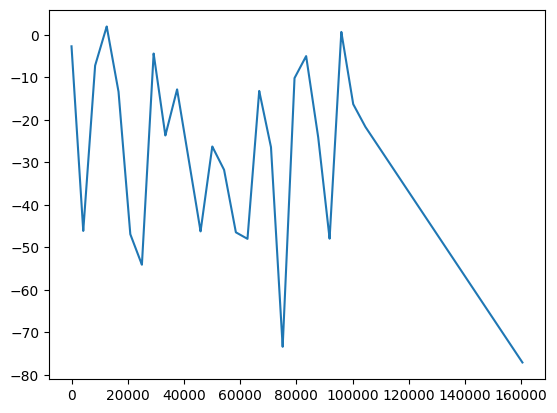

In [125]:
plt.plot(forecast.index,forecast['trend'])

In [86]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01 00:00:00,0.166569,-16.569269,18.077421,0.166569,0.166569,0.731907,0.731907,0.731907,1.238672,1.238672,1.238672,-0.506765,-0.506765,-0.506765,0.0,0.0,0.0,0.898476
1,2023-01-01 00:01:00,0.156790,-16.639745,18.209214,0.156790,0.156790,0.731842,0.731842,0.731842,1.240389,1.240389,1.240389,-0.508548,-0.508548,-0.508548,0.0,0.0,0.0,0.888631
2,2023-01-01 00:02:00,0.147010,-15.751222,18.254084,0.147010,0.147010,0.731732,0.731732,0.731732,1.242062,1.242062,1.242062,-0.510330,-0.510330,-0.510330,0.0,0.0,0.0,0.878742
3,2023-01-01 00:03:00,0.137230,-16.322886,17.673106,0.137230,0.137230,0.731579,0.731579,0.731579,1.243691,1.243691,1.243691,-0.512112,-0.512112,-0.512112,0.0,0.0,0.0,0.868809
4,2023-01-01 00:04:00,0.127451,-16.500300,19.139564,0.127451,0.127451,0.731381,0.731381,0.731381,1.245274,1.245274,1.245274,-0.513893,-0.513893,-0.513893,0.0,0.0,0.0,0.858831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131449,2023-04-02 06:49:00,-46.173079,-65.332030,-31.671601,-46.173079,-46.173079,-2.792202,-2.792202,-2.792202,-1.666792,-1.666792,-1.666792,-1.125410,-1.125410,-1.125410,0.0,0.0,0.0,-48.965281
131450,2023-04-02 06:50:00,-46.173996,-65.880820,-32.160775,-46.173996,-46.173996,-2.804365,-2.804365,-2.804365,-1.677891,-1.677891,-1.677891,-1.126473,-1.126473,-1.126473,0.0,0.0,0.0,-48.978361
131451,2023-04-02 06:51:00,-46.174914,-66.024031,-32.548745,-46.174914,-46.174914,-2.816449,-2.816449,-2.816449,-1.688915,-1.688915,-1.688915,-1.127534,-1.127534,-1.127534,0.0,0.0,0.0,-48.991363
131452,2023-04-02 06:52:00,-46.175832,-67.729191,-30.677627,-46.175832,-46.175832,-2.828453,-2.828453,-2.828453,-1.699861,-1.699861,-1.699861,-1.128592,-1.128592,-1.128592,0.0,0.0,0.0,-49.004285
